In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_clusters_gaussians.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
Meshcat url:  http://127.0.0.1:7004/static/


In [3]:
# Sample a dataset of scenes from the default grammar params.
# Draw a random sample from the grammar and visualize it.
# (Cache output.)
torch.random.manual_seed(2)
N_samples = 10
RESAMPLE = True
scenes_file = "sampled_scenes_%d.dat" % N_samples

ground_truth_grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4)
)

if not os.path.exists(scenes_file) or RESAMPLE:
    samples = []
    for k in tqdm(range(N_samples)):
        tree = ground_truth_grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))

    print("Saving...")
    with open(scenes_file, "wb") as f:
        pickle.dump(samples, f)

print("Loading...")
with open(scenes_file, "rb") as f:
    samples = pickle.load(f)
print("Loaded %d scenes." % len(samples))
observed_node_sets = [x[1] for x in samples]

draw_scene_tree_contents_meshcat(samples[0][0], zmq_url=vis.window.zmq_url, prefix="sample")

[2021-09-16 01:28:01.721] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.



Saving...
Loading...
Loaded 10 scenes.


/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


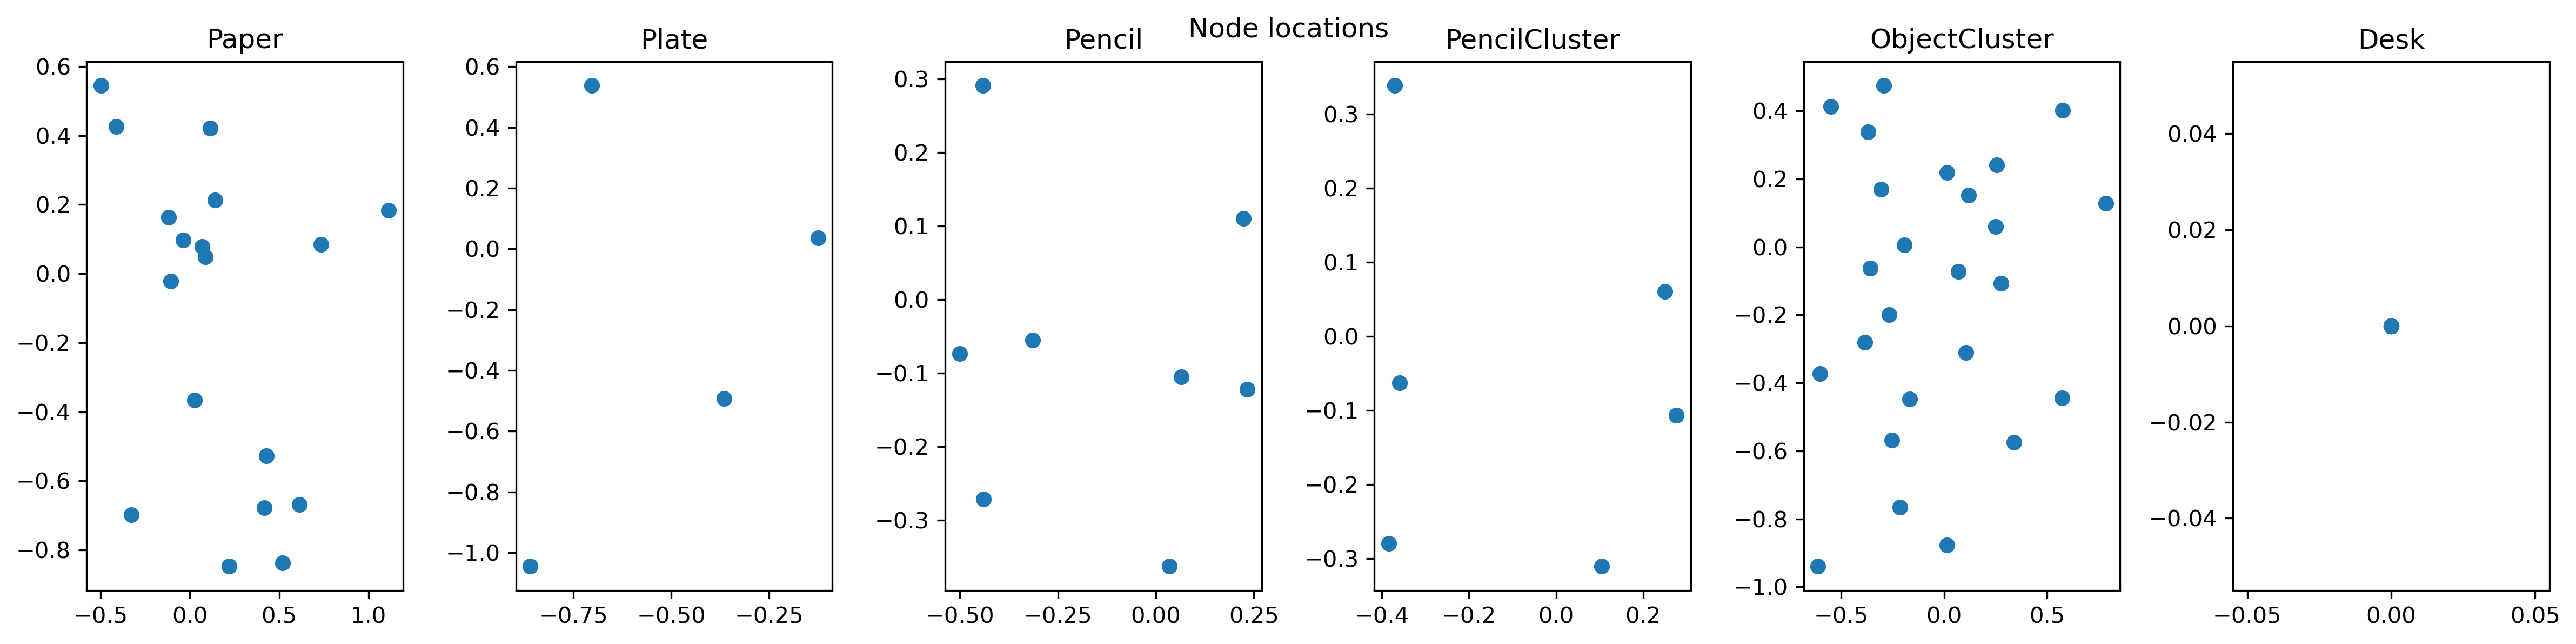

In [4]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)

# Draw histograms of planar locations of a few node types of interest
node_types_to_scatter = [Paper, Plate, Pencil, PencilCluster, ObjectCluster, Desk]
plt.figure(dpi=300).set_size_inches(16, 4)
plt.subplot(1, len(node_types_to_scatter), 1)
plt.suptitle("Node locations")
for k, node_type in enumerate(node_types_to_scatter):
    plt.subplot(1, len(node_types_to_scatter), k+1)
    plt.title(node_type.__name__)
    l = get_all_node_xyzs([sample[0] for sample in samples], node_type)
    plt.scatter(l[:, 0], l[:, 1], label=node_type.__name__)
plt.tight_layout()

In [22]:
# Randomly reset parameters and try to recover them.
torch.random.manual_seed(42)
random_grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
svi = SVIWrapper(random_grammar, [sample[1] for sample in samples])
svi.do_iterated_vi_fitting(major_iterations=20, minor_iterations=30, base_lr=0.1, tqdm=tqdm, num_elbo_samples=1, subsample=10, clip=10.)

Desk
Final params:  tensor([0.1326])
0:xyz:mean final: tensor([-0.0313,  0.0112])
0:xyz:variance final: tensor([6.1118, 6.6251])
0:rot:loc final: tensor([3.1037])
0:rot:concentration final: tensor([2.0259])
Pencil cluster
Final params:  tensor([0.4323])
0:xyz:mean final: tensor([-0.1630, -0.0719])
0:xyz:variance final: tensor([2.0026, 1.1922])
0:rot:loc final: tensor([6.1645])
0:rot:concentration final: tensor([0.9833])


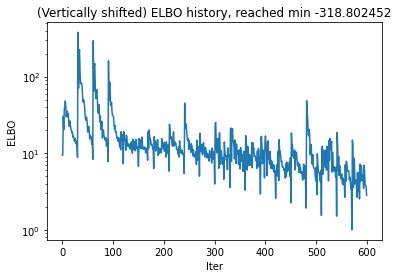

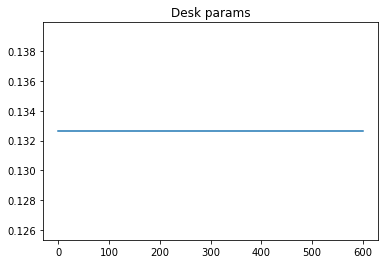

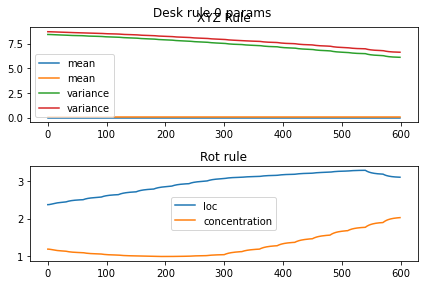

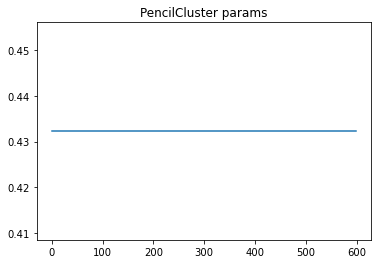

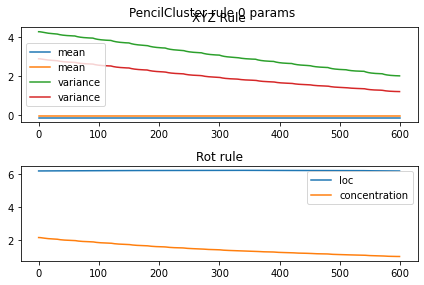

In [18]:
svi.plot_elbo_history()
print("Desk")
svi.plot_grammar_parameter_history(Desk)
print("Pencil cluster")
svi.plot_grammar_parameter_history(PencilCluster)

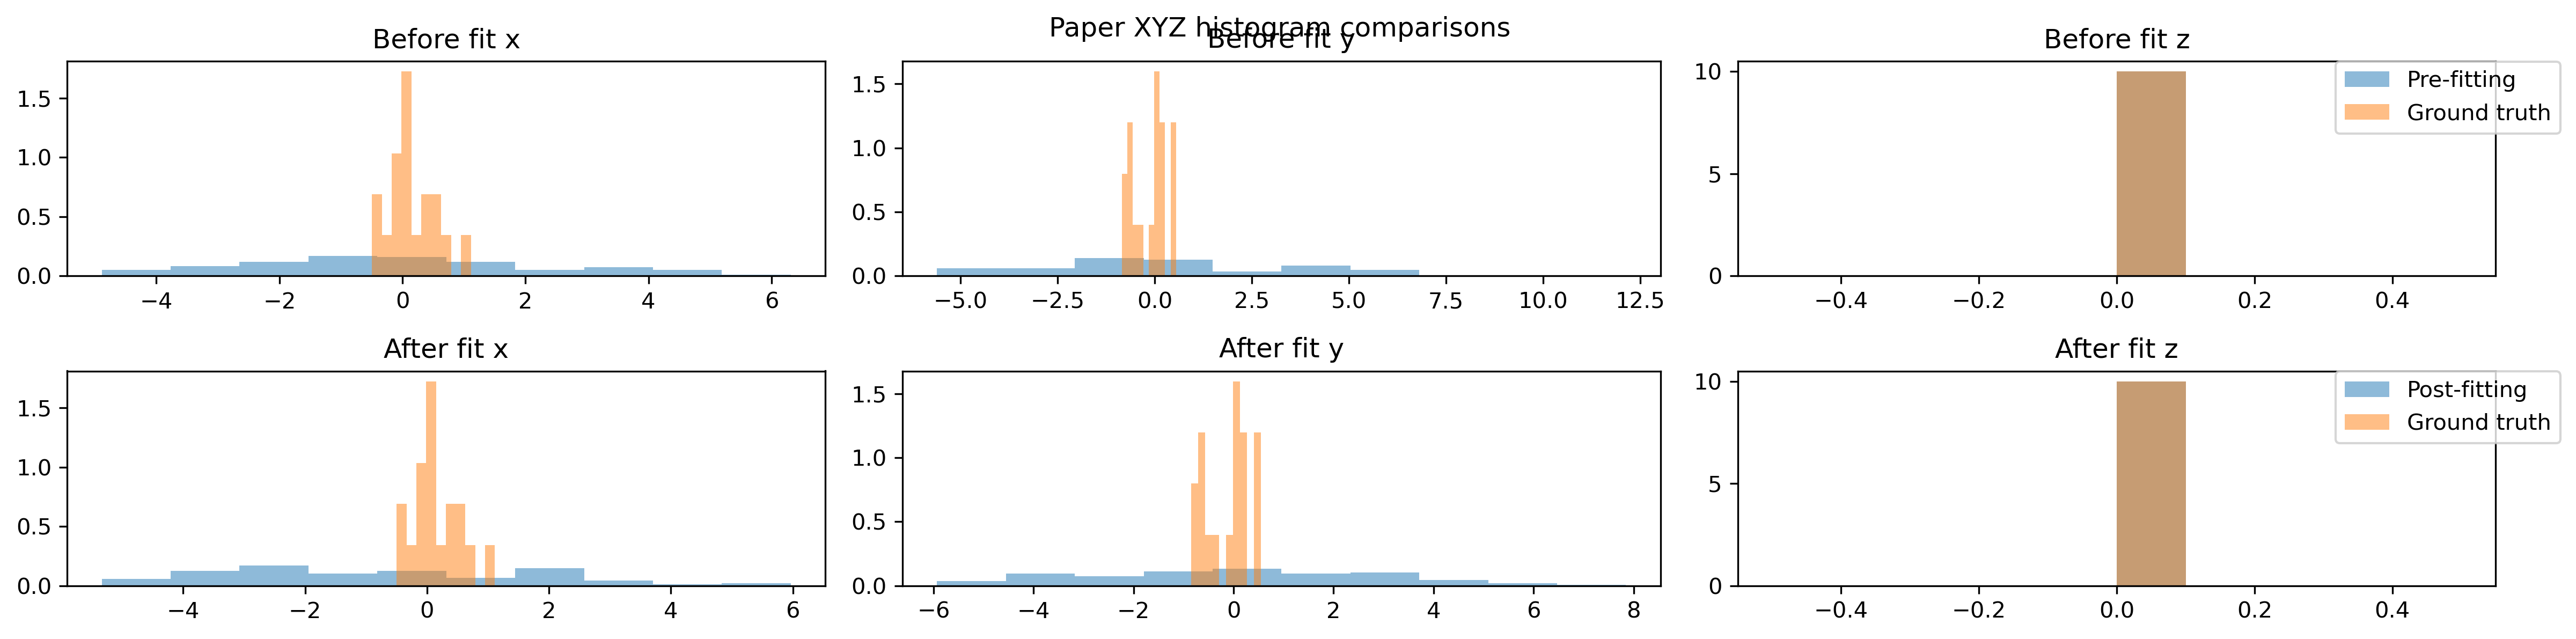

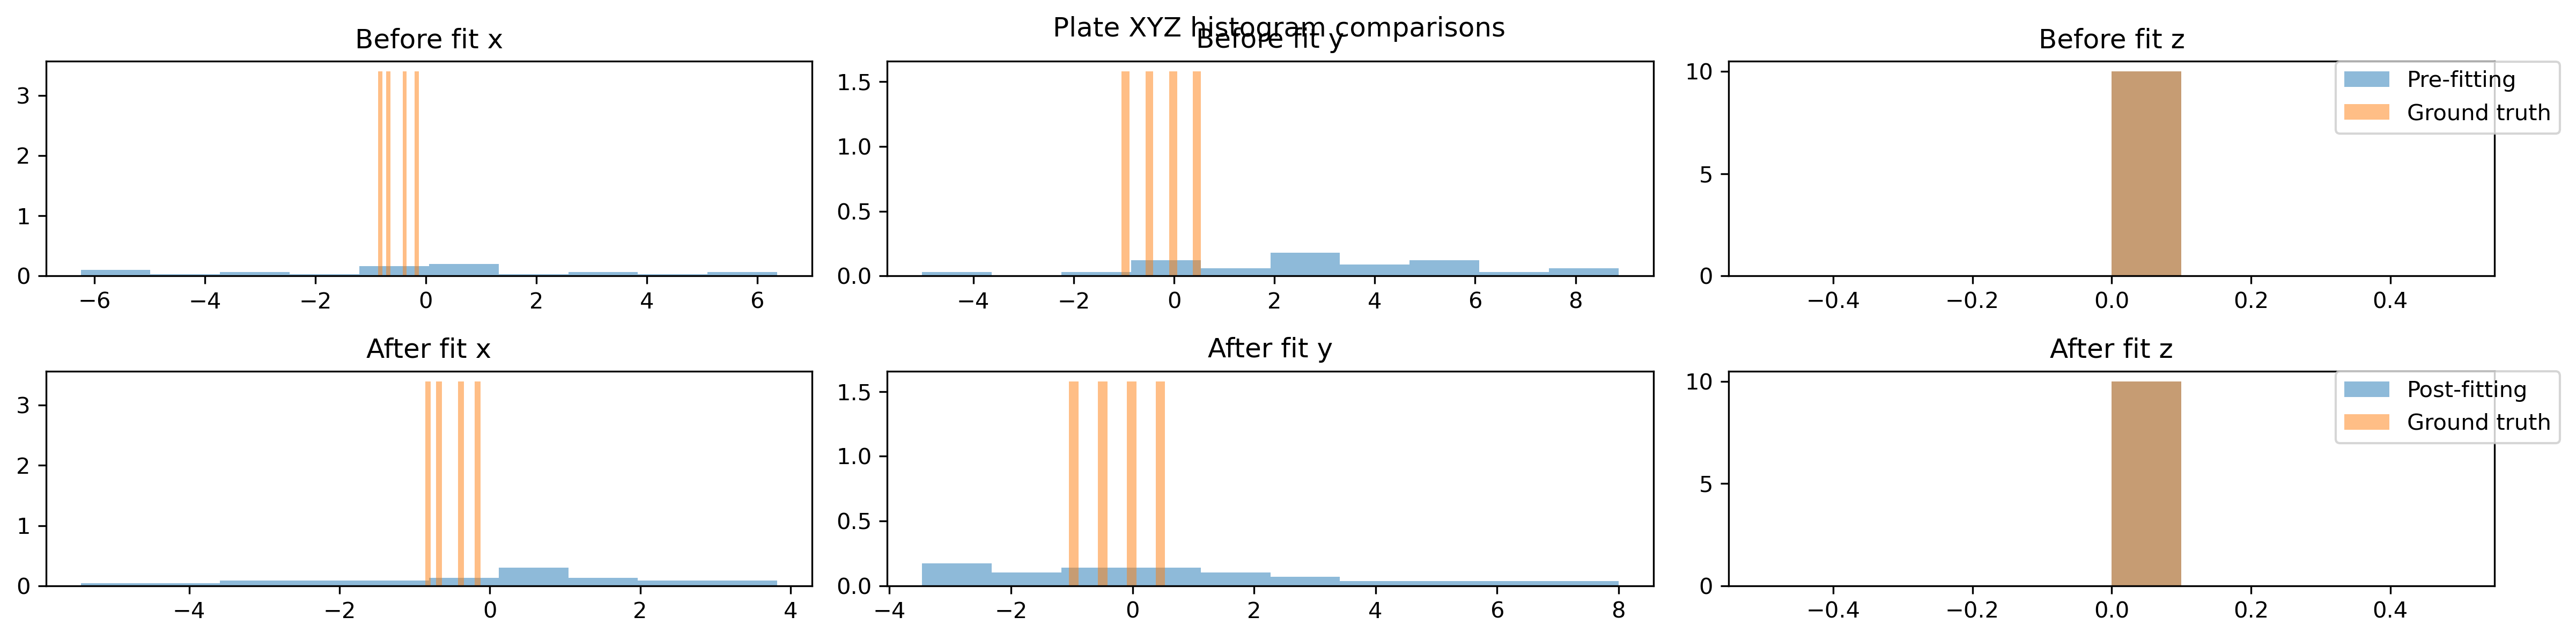

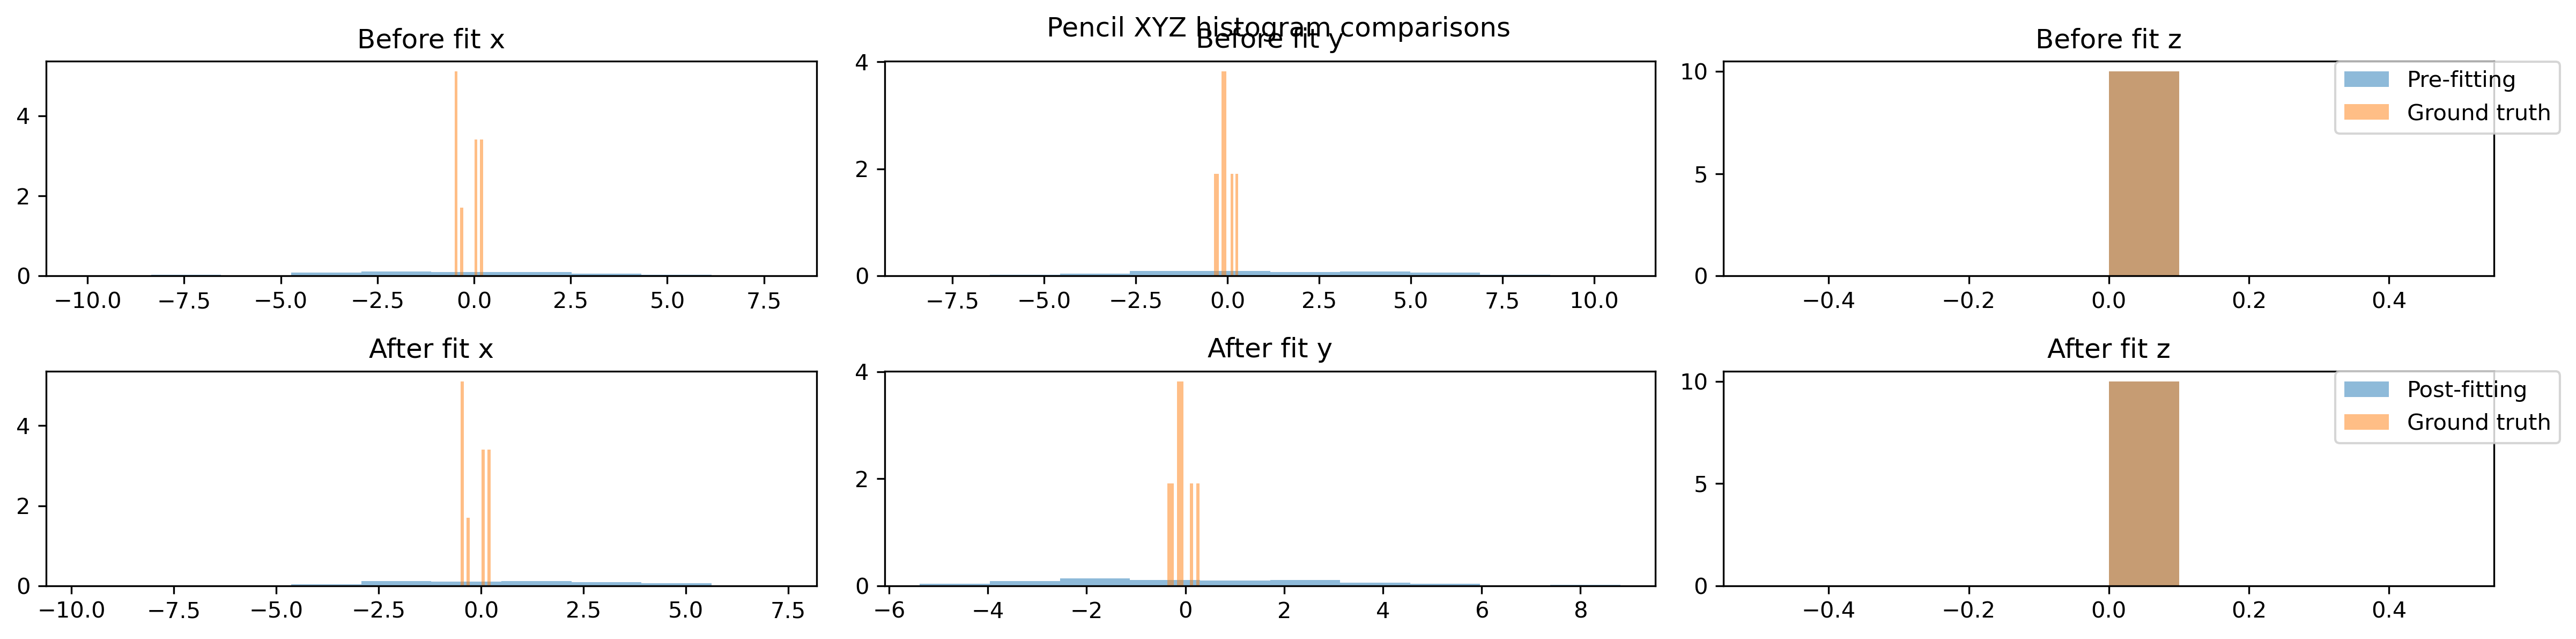

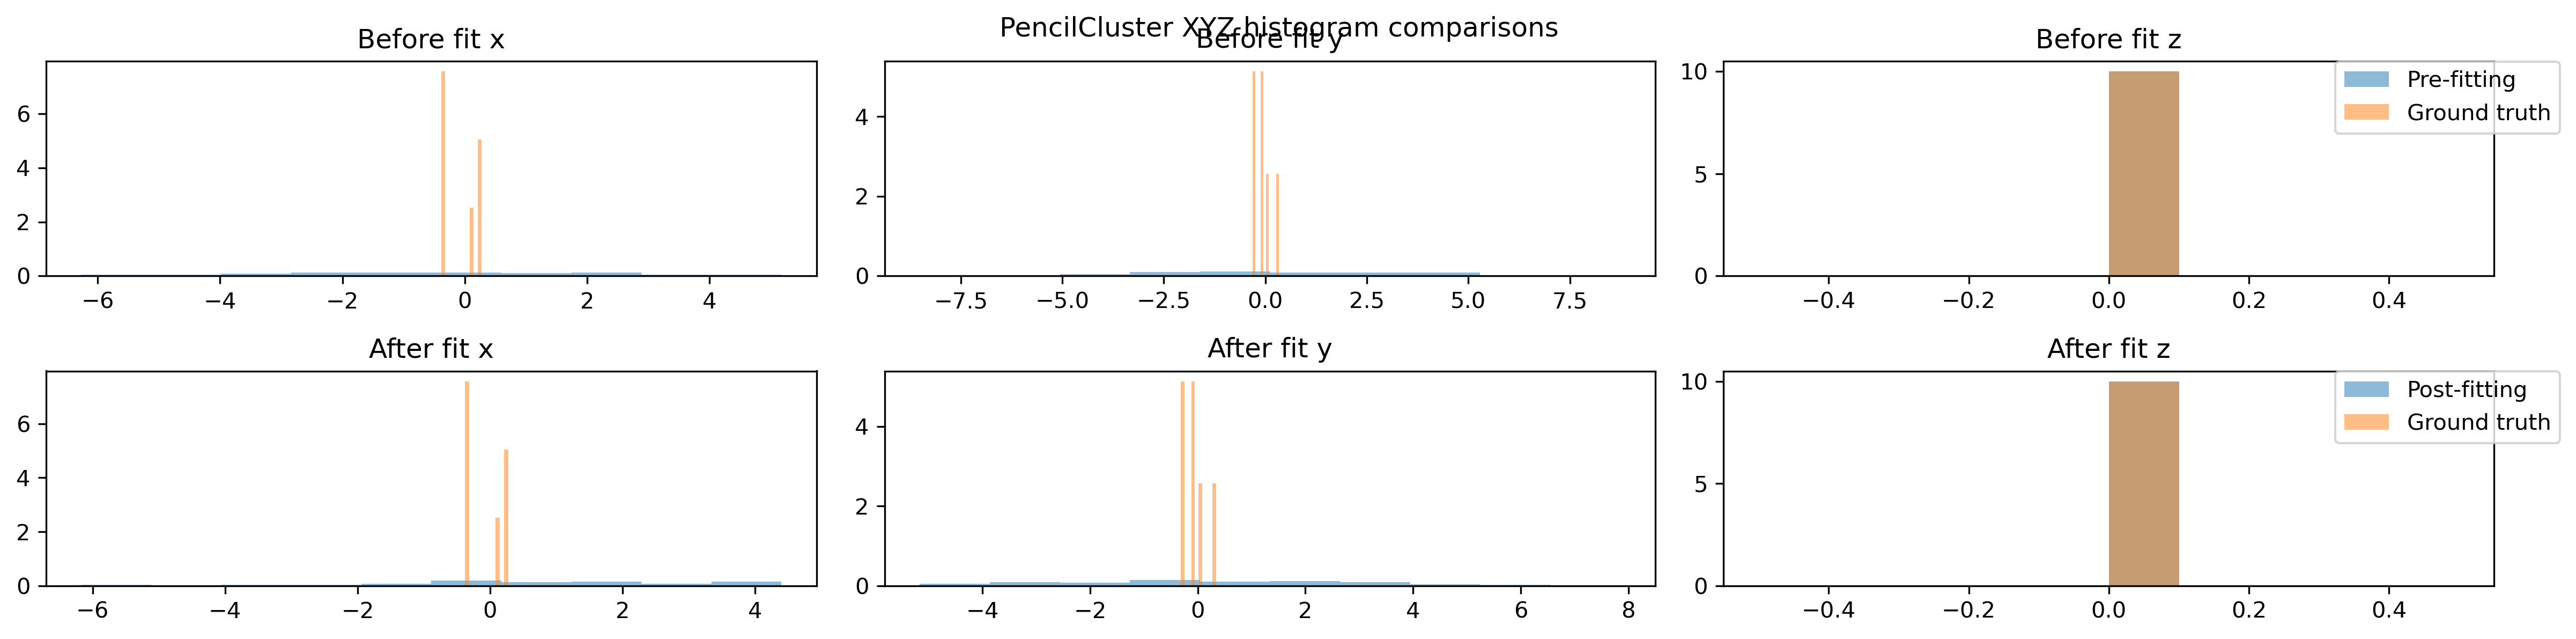

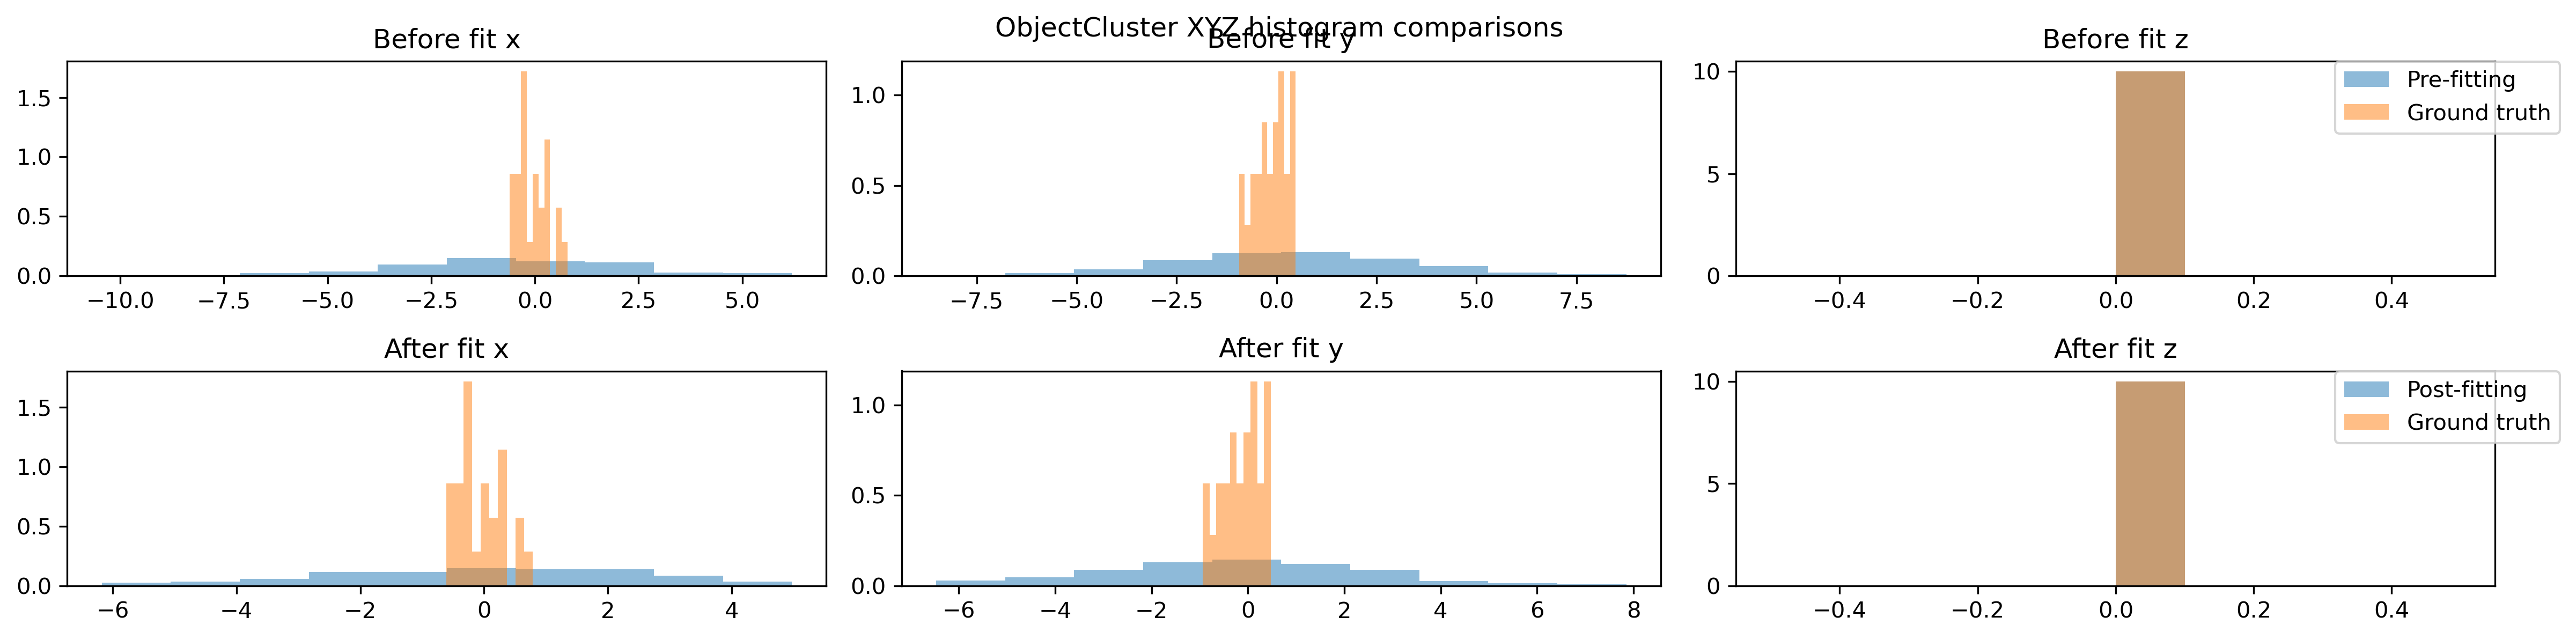

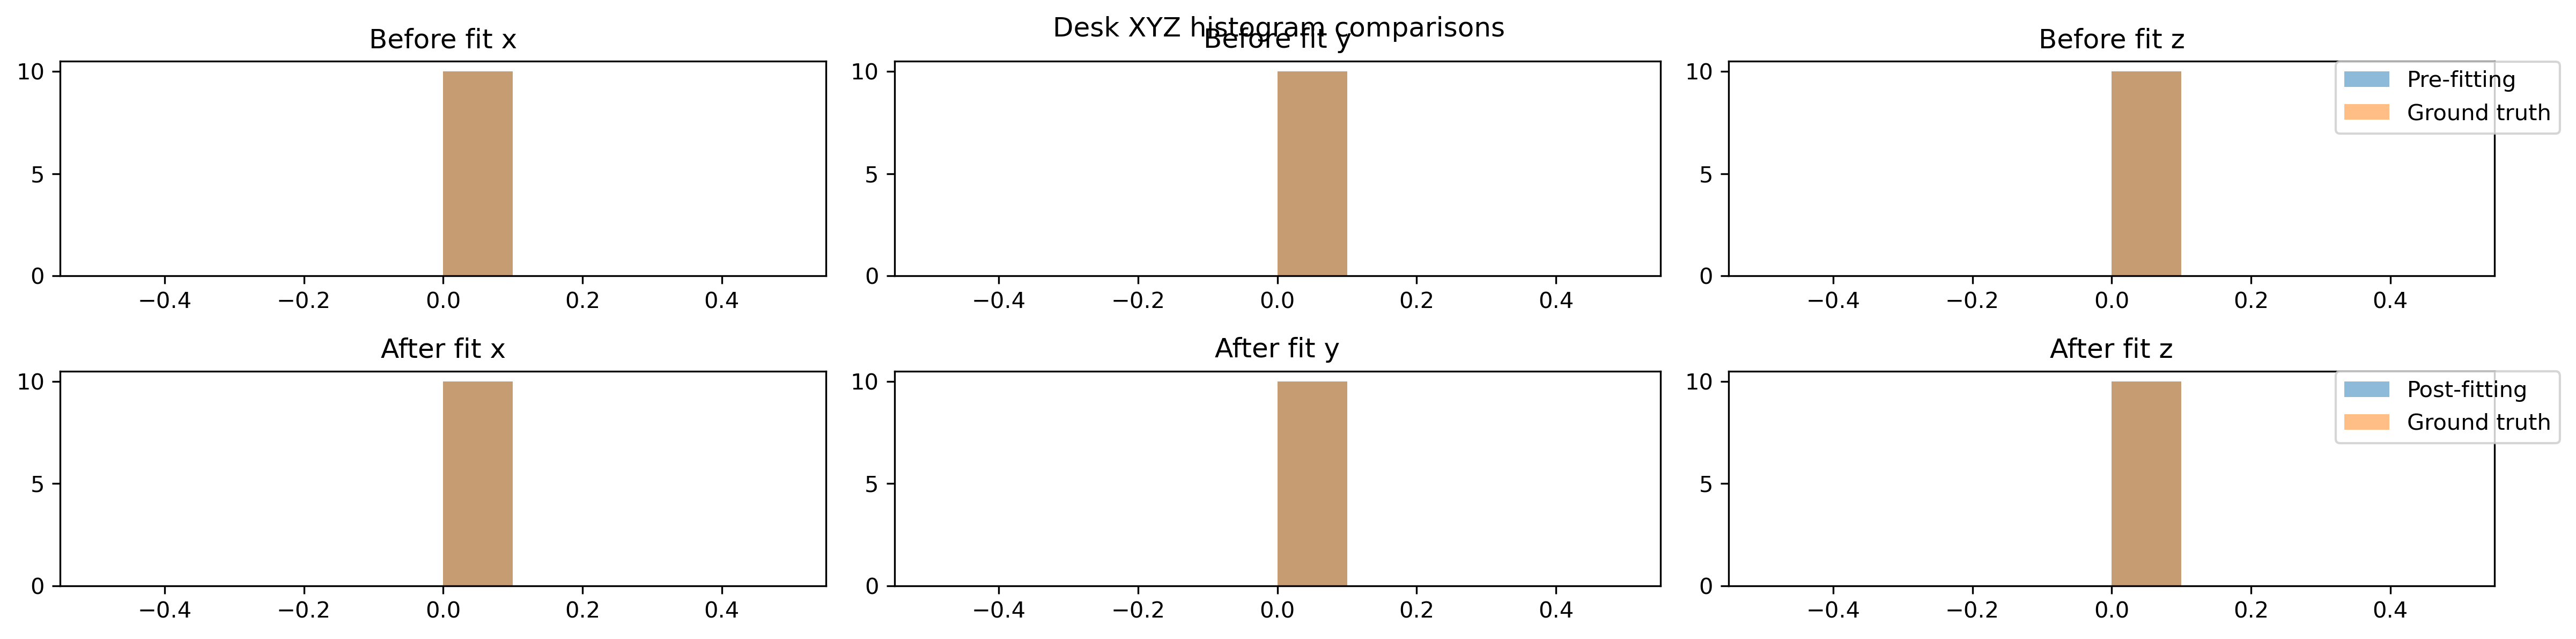

In [19]:
def plot_post_fit_tree_samples(self, N_samples=100):
    pre_fit_samples= []
    self.grammar.load_state_dict(self.grammar_major_iters[0][0])
    for k in range(N_samples):
        pre_fit_samples.append(self.grammar.sample_tree(detach=True))
    fit_samples = []
    self.grammar.load_state_dict(self.grammar_major_iters[-1][-1])
    for k in range(N_samples):
        fit_samples.append(self.grammar.sample_tree(detach=True))

    for node_type in node_types_to_scatter:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([sample[0] for sample in samples], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(svi, N_samples=50)

In [20]:
# Draw some fit-grammar-generated trees
for k in range(10):
    tree = random_grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_sample_%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_sample_%d/structure" % k)

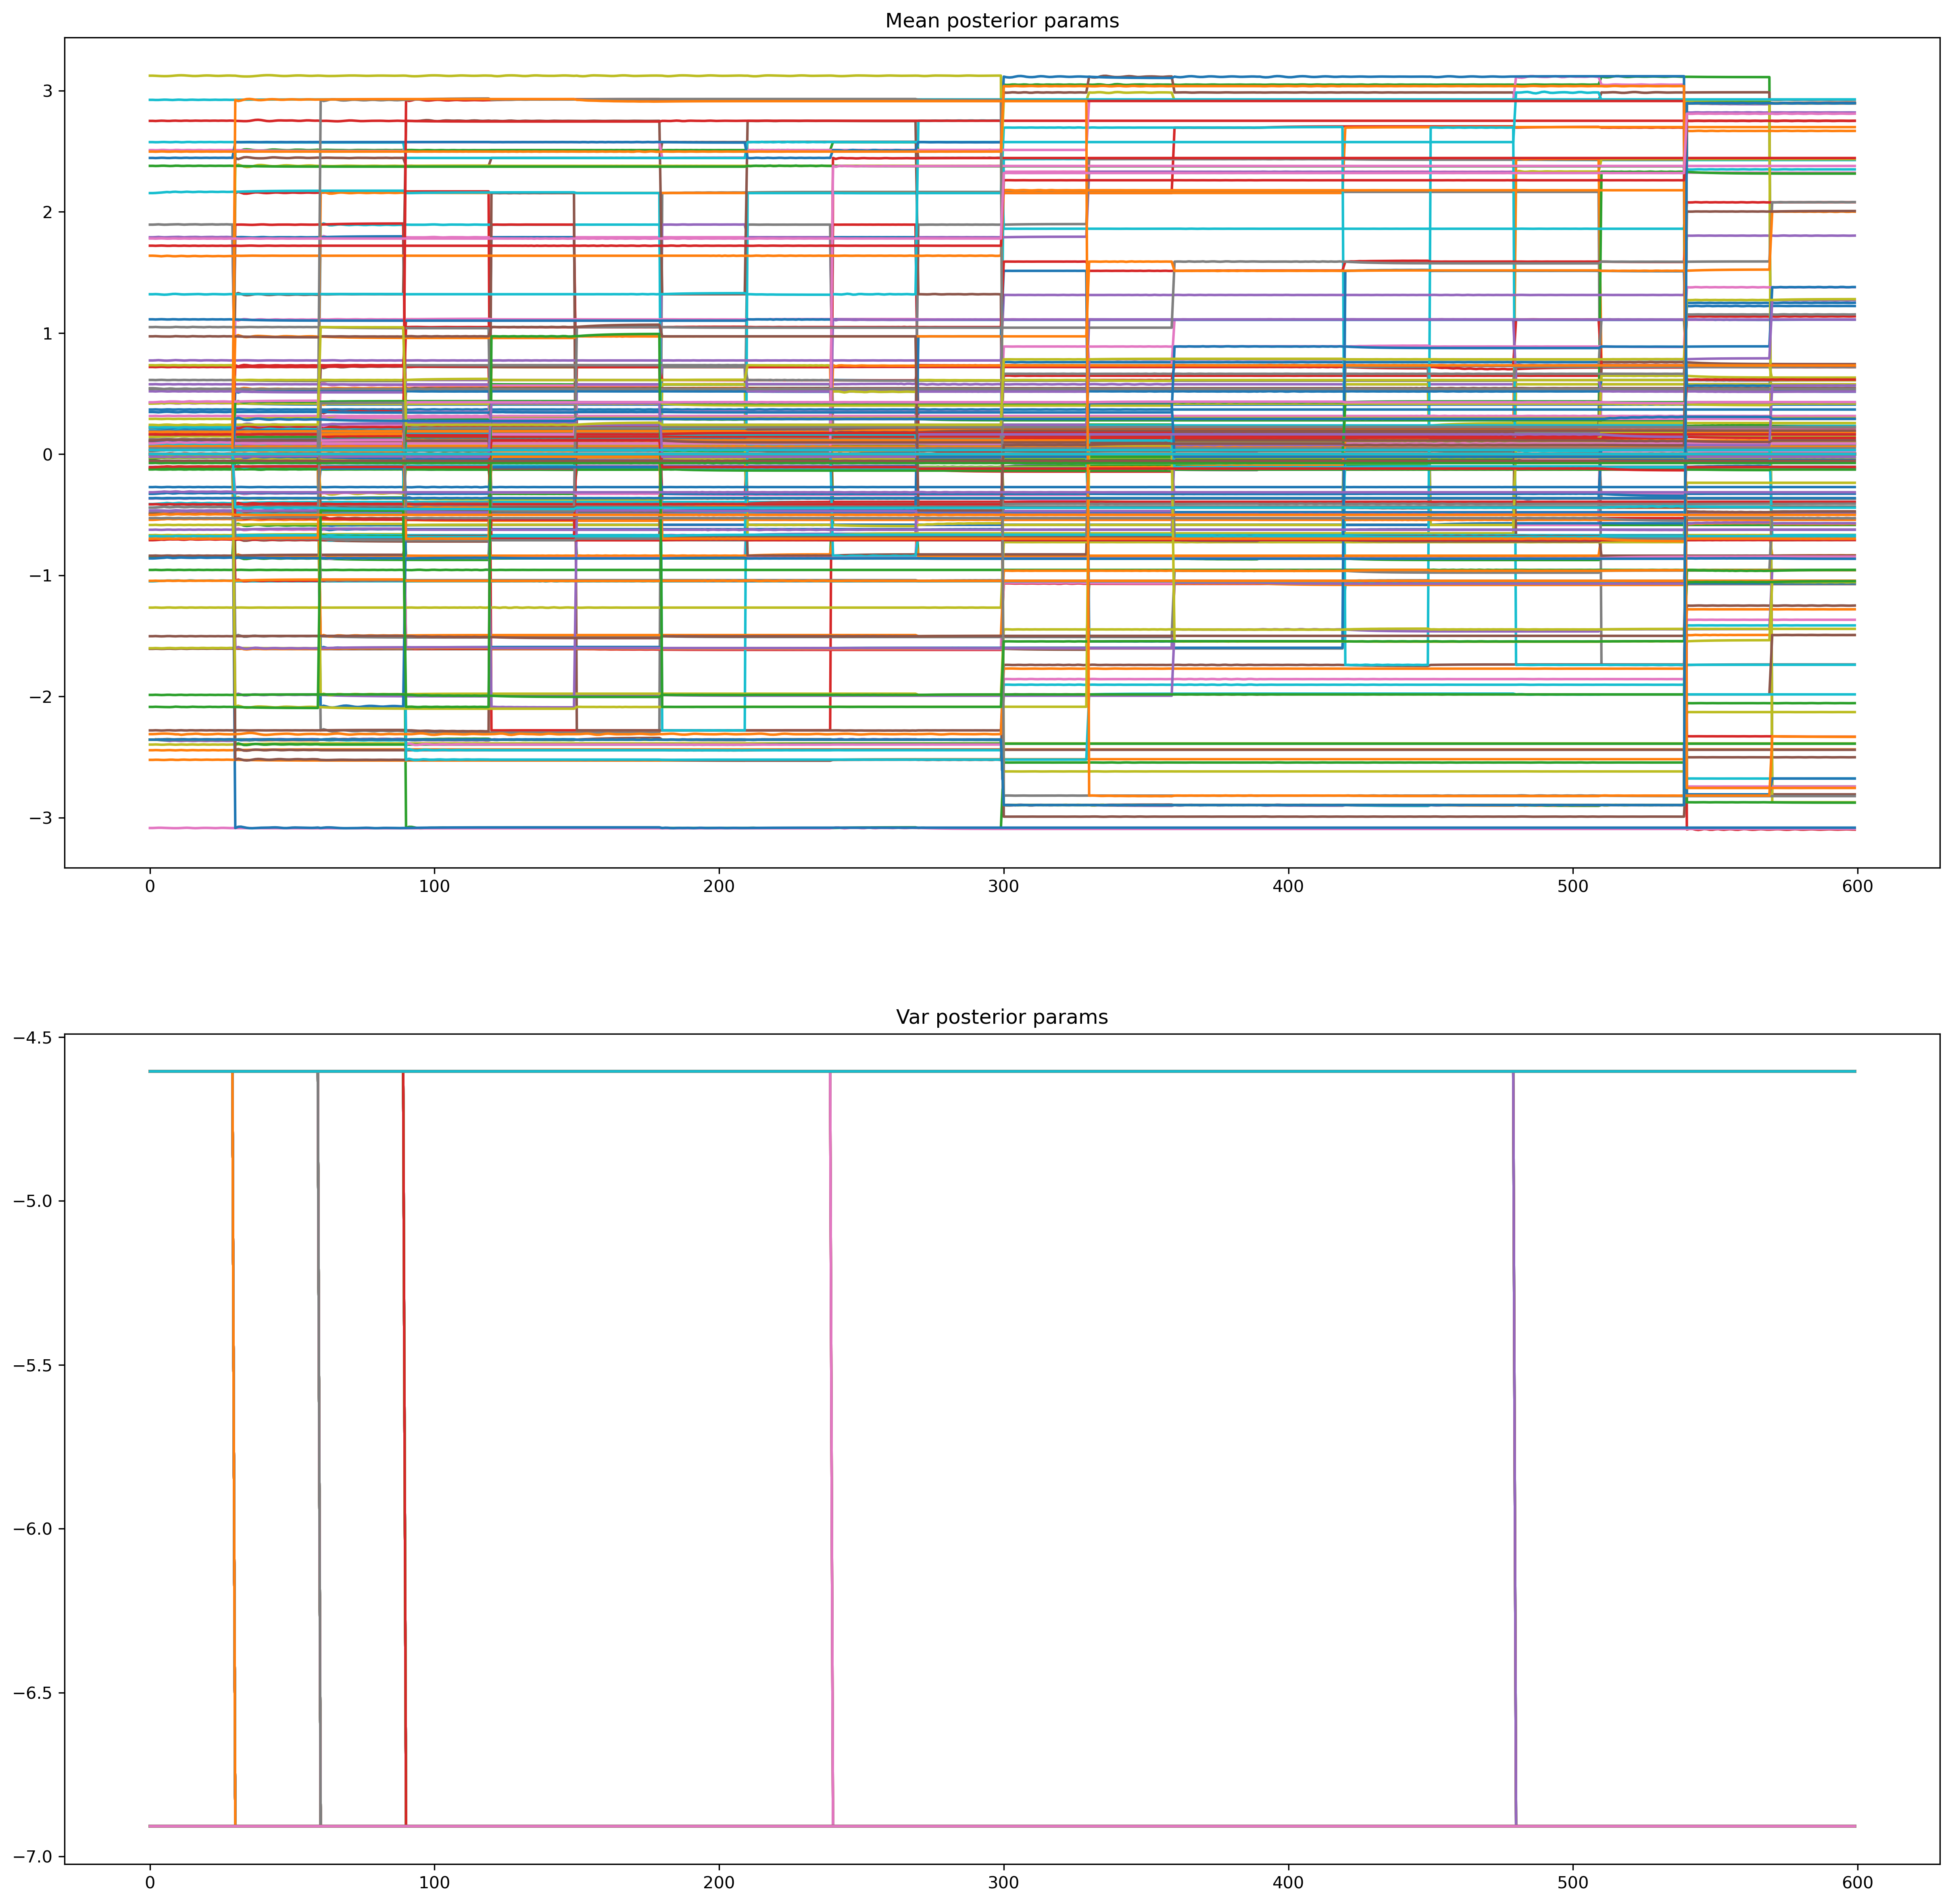

In [21]:
# Plot variational posterior parameters over optimization
def plot_posterior_params(self):
    svi_param_hists = [{} for k in range(len(self.observed_node_sets))]
    for posteriors, posterior_histories in self.posterior_major_iters:
        for state_dict in posterior_histories:
            posteriors.load_state_dict(state_dict)
            for k, posterior in enumerate(posteriors):
                hist_dict = svi_param_hists[k]
                for key, value in posterior.named_parameters():
                    if key not in hist_dict:
                        hist_dict[key] = []
                    hist_dict[key].append(deepcopy(value.detach()))
    plt.figure(dpi=300).set_size_inches(20, 20)
    ax1 = plt.subplot(2, 1, 1)
    plt.title("Mean posterior params")
    ax2 = plt.subplot(2, 1, 2)
    plt.title("Var posterior params")
    for param_hist in svi_param_hists:
        for key, value in param_hist.items():
            data = torch.stack(value).detach().numpy()
            if "mean" in key.split(".")[0]:
                ax1.plot(data)
            else:
                ax2.plot(data)

plot_posterior_params(svi)
